If you're using Google Colab, don't forget to save a copy of this notebook!

# Assignment 7 – train an autoencoder and VAE, and understand how they work

In [1]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", device)


Device: cuda


In [2]:
# Load datasets

data_root = "./data"

cifar_transform = transforms.ToTensor()

cifar_train_full = datasets.CIFAR10(root=data_root, train=True, transform=cifar_transform, download=True)
cifar_test = datasets.CIFAR10(root=data_root, train=False, transform=cifar_transform, download=True)
cifar_train, cifar_val = random_split(cifar_train_full, [45000, 5000], generator=torch.Generator().manual_seed(SEED))

cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
cifar_val_loader   = DataLoader(cifar_val,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
cifar_test_loader  = DataLoader(cifar_test,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print("CIFAR-10:", len(cifar_train), len(cifar_val), len(cifar_test))

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


CIFAR-10: 45000 5000 10000


The encoder and decoder parts are given to you:

In [3]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1, out_dim=16, base_channels=32, image_size=28, vae_heads=False):
        super().__init__()
        # Down: s -> s/2 -> s/4 -> s/8
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 4, 2, 1),  # s/2
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),  # s/4
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),  # s/8
            nn.ReLU(inplace=True),
        )
        s8 = image_size // 8  # 28->3, 32->4
        self.s8 = s8
        feat_dim = (base_channels*4) * s8 * s8
        self.flatten = nn.Flatten()
        if vae_heads:
            self.fc_mu = nn.Linear(feat_dim, out_dim)
            self.fc_logvar = nn.Linear(feat_dim, out_dim)
            self.out_kind = "vae"
        else:
            self.fc = nn.Linear(feat_dim, out_dim)
            self.out_kind = "ae"

    def forward(self, x):
        h = self.net(x)
        h = self.flatten(h)
        if self.out_kind == "vae":
            mu = self.fc_mu(h)
            logvar = self.fc_logvar(h)
            return mu, logvar
        else:
            z = self.fc(h)
            return z


class ConvDecoder(nn.Module):
    def __init__(self, out_channels=1, in_dim=16, base_channels=32, image_size=28):
        super().__init__()
        s8 = image_size // 8  # 28->3, 32->4
        self.s8 = s8
        self.image_size = image_size
        self.base_channels = base_channels
        feat_dim = (base_channels*4) * s8 * s8
        self.fc = nn.Linear(in_dim, feat_dim)

        self.net = nn.Sequential(
            # Upsample to s/4 and apply Conv2d
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1),
            nn.ReLU(inplace=True),
            # Upsample to s/2 and apply Conv2d
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels*2, base_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            # Upsample to s and apply Conv2d
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels, out_channels, 3, 1, 1),
            nn.Sigmoid()
        )


    def forward(self, z):
        h = self.fc(z)
        h = h.view(z.size(0), self.base_channels*4, self.s8, self.s8)
        x_hat = self.net(h)

        # Resize the output to the exact image_size if necessary
        if x_hat.size(2) != self.image_size or x_hat.size(3) != self.image_size:
            x_hat = F.interpolate(x_hat, size=(self.image_size, self.image_size), mode='nearest')

        return x_hat

# Part A (In-Lab 2%)

## A.1 Autoencoder

Construct the full autoencoder architecture from the given parts

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, image_size=32, latent_dim=8, base_channels=32):
        super().__init__()
        self.encoder = ConvEncoder(
            in_channels=in_channels,
            out_dim=latent_dim,
            base_channels=base_channels,
            image_size=image_size,
        )
        self.decoder = ConvDecoder(
            out_channels=in_channels,
            in_dim=latent_dim,
            base_channels=base_channels,
            image_size=image_size
        )
        self.latent_dim = latent_dim

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


Write the loss computation part.

In [5]:
def ae_loss(x, x_hat, reduction="mean"):
    """Autoencoder reconstruction loss (BCE per pixel)"""
    # BCE loss per pixel
    bce = F.binary_cross_entropy(x_hat, x, reduction='none')
    # Sum over channels, height, width -> shape: (batch_size,)
    bce = bce.sum(dim=(1, 2, 3))
    # Divide by total pixels per image (C * H * W) to get per-pixel error
    bce = bce / (x.size(1) * x.size(2) * x.size(3))

    if reduction == "mean":
        return bce.mean()
    elif reduction == "sum":
        return bce.sum()
    else:
        return bce

The training code is provided to you

In [6]:
def train_ae_epoch(model, loader, opt):
    model.train()
    total_loss = 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        opt.zero_grad()
        x_hat, _ = model(x)
        loss = ae_loss(x, x_hat, reduction="mean")
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_ae(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device, non_blocking=True)
            x_hat, _ = model(x)
            loss = ae_loss(x, x_hat, reduction="mean")
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

Train the autoencoder on the CIFAR-10 dataset. You may have to choose appropriate hyperparameters

In [7]:
# Hyperparameters
cifar_latent = 128
cifar_base = 64
epochs_ae = 15
lr = 1e-3

print("\n" + "="*60)
print("PART A.1: TRAINING AUTOENCODER")
print("="*60)
print(f"Latent dim: {cifar_latent}, Base channels: {cifar_base}")
print(f"Learning rate: {lr}, Epochs: {epochs_ae}")
print("="*60 + "\n")

ae_cifar = Autoencoder(in_channels=3, image_size=32, latent_dim=cifar_latent, base_channels=cifar_base).to(device)
opt_ae = optim.Adam(ae_cifar.parameters(), lr=lr)

best_val = float("inf")
best_state = None
for epoch in range(1, epochs_ae+1):
    t0 = time.time()
    tr = train_ae_epoch(ae_cifar, cifar_train_loader, opt_ae)
    val = eval_ae(ae_cifar, cifar_val_loader)
    dt = time.time() - t0
    print(f"[AE][Epoch {epoch}] train={tr:.4f} val={val:.4f} time={dt:.1f}s")
    if val < best_val:
        best_val = val
        best_state = {k: v.cpu().clone() for k, v in ae_cifar.state_dict().items()}

# Load best model
if best_state is not None:
    ae_cifar.load_state_dict(best_state, strict=True)
    ae_cifar = ae_cifar.to(device)
    print(f"\nBest validation loss: {best_val:.4f}")


PART A.1: TRAINING AUTOENCODER
Latent dim: 128, Base channels: 64
Learning rate: 0.001, Epochs: 15

[AE][Epoch 1] train=0.6017 val=0.5797 time=11.0s
[AE][Epoch 2] train=0.5760 val=0.5722 time=8.5s
[AE][Epoch 3] train=0.5705 val=0.5682 time=8.6s
[AE][Epoch 4] train=0.5665 val=0.5654 time=7.9s
[AE][Epoch 5] train=0.5641 val=0.5650 time=8.5s
[AE][Epoch 6] train=0.5626 val=0.5623 time=8.7s
[AE][Epoch 7] train=0.5613 val=0.5613 time=9.2s
[AE][Epoch 8] train=0.5607 val=0.5605 time=8.2s
[AE][Epoch 9] train=0.5601 val=0.5602 time=8.8s
[AE][Epoch 10] train=0.5599 val=0.5597 time=8.4s
[AE][Epoch 11] train=0.5596 val=0.5596 time=8.0s
[AE][Epoch 12] train=0.5593 val=0.5596 time=8.8s
[AE][Epoch 13] train=0.5591 val=0.5594 time=8.8s
[AE][Epoch 14] train=0.5590 val=0.5591 time=7.9s
[AE][Epoch 15] train=0.5590 val=0.5592 time=8.8s

Best validation loss: 0.5591


Show a few example reconstructions from the images in the dataset.

In [8]:
def show_reconstructions(model, loader, device, n=6):
    """Show original and reconstructed images side by side"""
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:n].to(device)

    with torch.no_grad():
        output = model(images)
        # Handle both AE (returns 2 values) and VAE (returns 4 values)
        if len(output) == 2:
            recons, _ = output  # Autoencoder
        else:
            recons, _, _, _ = output  # VAE

    images = images.cpu()
    recons = recons.cpu()

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        # Original
        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].set_title(f'Original (Label: {labels[i]})')
        axes[0, i].axis('off')

        # Reconstruction
        axes[1, i].imshow(recons[i].permute(1, 2, 0).numpy())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

Write a function that samples a latent variable and runs the decoder for image generation.

In [9]:
def sample_from_decoder(decoder, latent_dim, device, n=8):
    """Sample random latent vectors and generate images"""
    decoder.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(n, latent_dim).to(device)
        samples = decoder(z).cpu()

    fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
    for i in range(n):
        axes[i].imshow(samples[i].permute(1, 2, 0).numpy())
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


AUTOENCODER RECONSTRUCTIONS


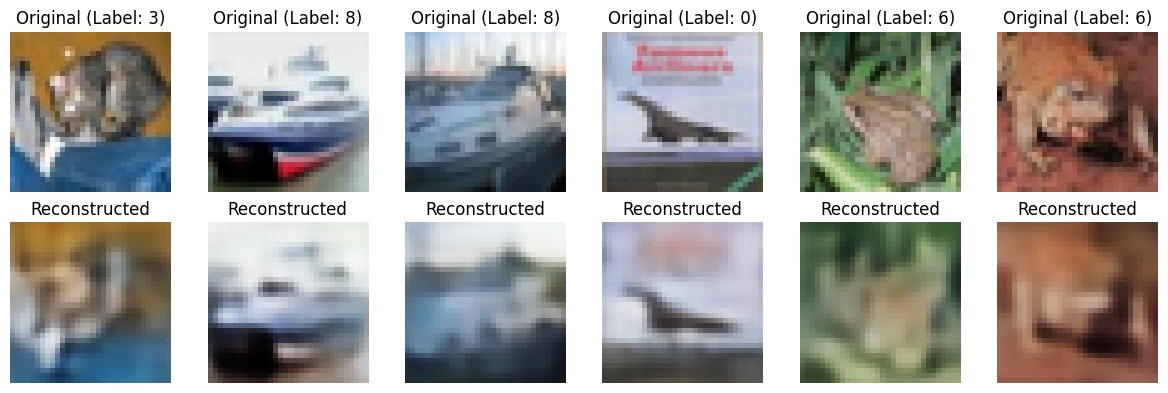


SAMPLING FROM DECODER


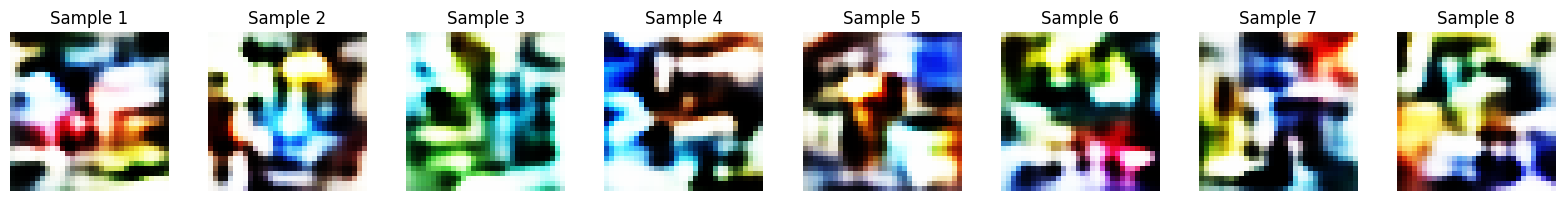


PART A.1 COMPLETE!


In [10]:
print("\n" + "="*60)
print("AUTOENCODER RECONSTRUCTIONS")
print("="*60)
show_reconstructions(ae_cifar, cifar_test_loader, device, n=6)

print("\n" + "="*60)
print("SAMPLING FROM DECODER")
print("="*60)
sample_from_decoder(ae_cifar.decoder, cifar_latent, device, n=8)

print("\n" + "="*60)
print("PART A.1 COMPLETE!")
print("="*60)


## A.2 VAE

Construct the full VAE architecture from the given parts

In [11]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, image_size=32, latent_dim=8, base_channels=32):
        super().__init__()
        self.encoder = ConvEncoder(
            in_channels=in_channels,
            out_dim=latent_dim,
            base_channels=base_channels,
            image_size=image_size,
            vae_heads=True  # Enable VAE heads (mu and logvar)
        )
        self.decoder = ConvDecoder(
            out_channels=in_channels,
            in_dim=latent_dim,
            base_channels=base_channels,
            image_size=image_size
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z

Write the loss computation part.

In [12]:
def vae_loss(x, x_hat, mu, logvar, beta=1.0, reduction="mean"):
    """
    VAE loss = Reconstruction loss (BCE per image) + beta * KL divergence
    Returns: (total_loss, recon_loss, kl_loss)

    Expected performance: recon_loss ~ 85 BCE per image
    """
    # Reconstruction loss: BCE per image (not per pixel like AE)
    bce = F.binary_cross_entropy(x_hat, x, reduction='none')
    # Sum over channels, height, width -> shape: (batch_size,)
    recon_loss = bce.sum(dim=(1, 2, 3))

    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KL per sample in batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    # Total loss per sample
    total_loss = recon_loss + beta * kl_loss

    if reduction == "mean":
        return total_loss.mean(), recon_loss.mean(), kl_loss.mean()
    elif reduction == "sum":
        return total_loss.sum(), recon_loss.sum(), kl_loss.sum()
    else:
        return total_loss, recon_loss, kl_loss

The training code is provided to you

In [13]:
def train_vae_epoch(model, loader, opt, beta=1.0):
    model.train()
    total, total_recon, total_kl = 0.0, 0.0, 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        opt.zero_grad()
        x_hat, mu, logvar, _ = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar, beta=beta, reduction="mean")
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
        total_recon += recon.item() * x.size(0)
        total_kl += kl.item() * x.size(0)
    n = len(loader.dataset)
    return total / n, total_recon / n, total_kl / n

def eval_vae(model, loader, beta=1.0):
    model.eval()
    total, total_recon, total_kl = 0.0, 0.0, 0.0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device, non_blocking=True)
            x_hat, mu, logvar, _ = model(x)
            loss, recon, kl = vae_loss(x, x_hat, mu, logvar, beta=beta, reduction="mean")
            total += loss.item() * x.size(0)
            total_recon += recon.item() * x.size(0)
            total_kl += kl.item() * x.size(0)
    n = len(loader.dataset)
    return total / n, total_recon / n, total_kl / n

Train the VAE on the CIFAR-10 dataset. You may have to choose appropriate hyperparameters

In [15]:
# Hyperparameters
cifar_latent = 128
cifar_base = 64
epochs_vae = 15
lr = 1e-3
beta = 1  # standard VAE

print(f"Latent dim: {cifar_latent}, Base channels: {cifar_base}")
print(f"Learning rate: {lr}, Epochs: {epochs_vae}, Beta: {beta}")
print("="*60 + "\n")

vae_cifar = VAE(in_channels=3, image_size=32, latent_dim=cifar_latent, base_channels=cifar_base).to(device)
opt_vae = optim.Adam(vae_cifar.parameters(), lr=lr)

best_val = float("inf")
best_state = None
for epoch in range(1, epochs_vae+1):
    t0 = time.time()
    tr, tr_rec, tr_kl = train_vae_epoch(vae_cifar, cifar_train_loader, opt_vae, beta=beta)
    val, val_rec, val_kl = eval_vae(vae_cifar, cifar_val_loader, beta=beta)
    dt = time.time() - t0
    print(f"[VAE][Epoch {epoch}] train={tr:.4f} (rec={tr_rec:.4f}, kl={tr_kl:.4f}) "
          f"val={val:.4f} (rec={val_rec:.4f}, kl={val_kl:.4f}) time={dt:.1f}s")
    if val < best_val:
        best_val = val
        best_state = {k: v.cpu() for k, v in vae_cifar.state_dict().items()}
vae_cifar.load_state_dict(best_state, strict=True)

# Load best model
if best_state is not None:
    vae_cifar.load_state_dict(best_state, strict=True)
    vae_cifar = vae_cifar.to(device)
    print(f"\nBest validation loss: {best_val:.4f}")

Latent dim: 128, Base channels: 64
Learning rate: 0.001, Epochs: 15, Beta: 1

[VAE][Epoch 1] train=1903.2192 (rec=1874.8985, kl=28.3207) val=1851.1298 (rec=1817.0718, kl=34.0581) time=9.8s
[VAE][Epoch 2] train=1841.9350 (rec=1807.6036, kl=34.3314) val=1837.7252 (rec=1802.4660, kl=35.2591) time=9.7s
[VAE][Epoch 3] train=1831.5944 (rec=1794.8857, kl=36.7086) val=1829.8968 (rec=1790.4373, kl=39.4595) time=8.2s
[VAE][Epoch 4] train=1828.4476 (rec=1790.1328, kl=38.3148) val=1827.3322 (rec=1788.2169, kl=39.1152) time=8.8s
[VAE][Epoch 5] train=1825.7204 (rec=1786.2666, kl=39.4538) val=1825.8772 (rec=1785.2394, kl=40.6379) time=9.0s
[VAE][Epoch 6] train=1823.8393 (rec=1783.6391, kl=40.2002) val=1825.3598 (rec=1785.5283, kl=39.8315) time=8.5s
[VAE][Epoch 7] train=1823.2390 (rec=1782.5283, kl=40.7107) val=1823.1089 (rec=1781.3946, kl=41.7143) time=8.6s
[VAE][Epoch 8] train=1821.9960 (rec=1780.7453, kl=41.2506) val=1822.0537 (rec=1780.3300, kl=41.7237) time=8.9s
[VAE][Epoch 9] train=1821.2169 (re

Show a few example reconstructions from the images in the dataset, and show a few generated images from decoding some latent variables (you may reuse the functions defined previously)


VAE RECONSTRUCTIONS


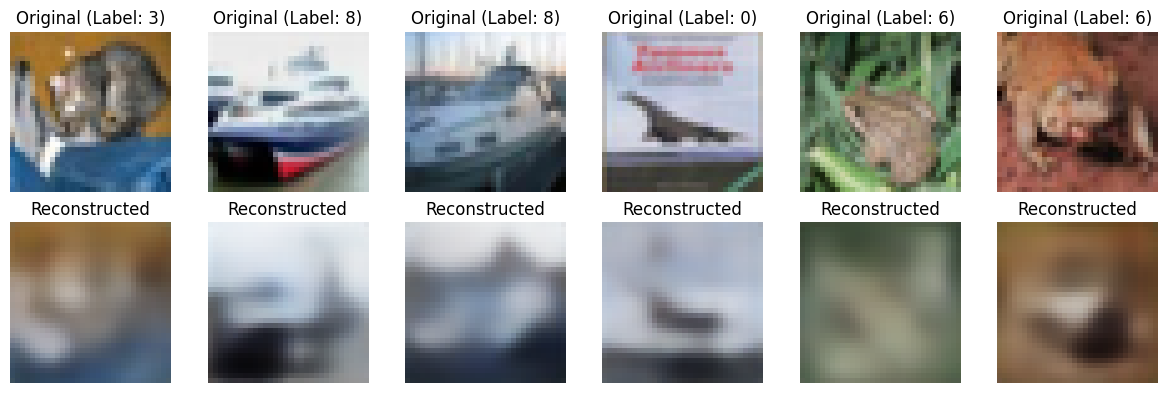


SAMPLING FROM VAE DECODER


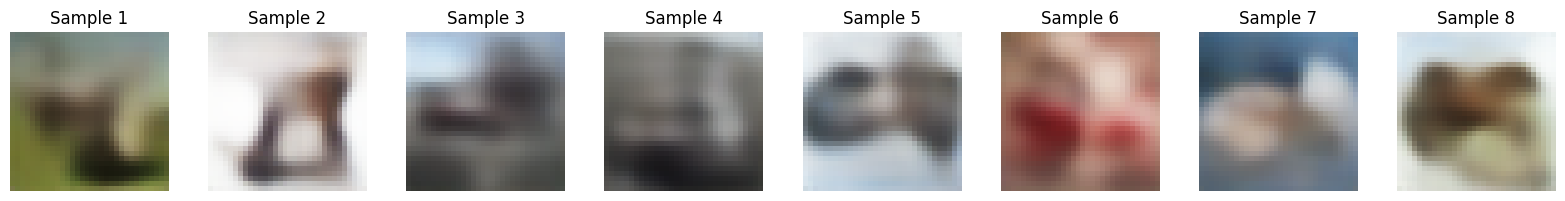

In [16]:
print("\n" + "="*60)
print("VAE RECONSTRUCTIONS")
print("="*60)
show_reconstructions(vae_cifar, cifar_test_loader, device, n=6)

print("\n" + "="*60)
print("SAMPLING FROM VAE DECODER")
print("="*60)
sample_from_decoder(vae_cifar.decoder, cifar_latent, device, n=8)


# Part B (Take-Home 3%)

## B.1 Tune VAE

Train at least 3 different configurations for the VAE, and measure their performance and runtime

In [17]:
print("\n" + "="*60)
print("PART B.1: TUNING VAE - TRAINING MULTIPLE CONFIGURATIONS")
print("="*60)

# Define configurations to test
configurations = [
    {
        'name': 'Config 1: Small Latent',
        'latent_dim': 4,
        'base_channels': 32,
        'lr': 3e-3,
        'beta': 1.0,
        'epochs': 10
    },
    {
        'name': 'Config 2: Standard (Baseline)',
        'latent_dim': 8,
        'base_channels': 32,
        'lr': 3e-3,
        'beta': 1.0,
        'epochs': 10
    },
    {
        'name': 'Config 3: Large Latent',
        'latent_dim': 16,
        'base_channels': 32,
        'lr': 3e-3,
        'beta': 1.0,
        'epochs': 10
    },
    {
        'name': 'Config 4: Deeper Network',
        'latent_dim': 8,
        'base_channels': 64,
        'lr': 3e-3,
        'beta': 1.0,
        'epochs': 10
    }
]

# Store results for comparison
results = []

for idx, config in enumerate(configurations):
    print(f"\n{'='*60}")
    print(f"Training {config['name']}")
    print(f"{'='*60}")
    print(f"Latent dim: {config['latent_dim']}, Base channels: {config['base_channels']}")
    print(f"Learning rate: {config['lr']}, Beta: {config['beta']}, Epochs: {config['epochs']}")
    print(f"{'='*60}\n")

    # Initialize model with current configuration
    vae_config = VAE(
        in_channels=3,
        image_size=32,
        latent_dim=config['latent_dim'],
        base_channels=config['base_channels']
    ).to(device)

    opt_config = optim.Adam(vae_config.parameters(), lr=config['lr'])

    # Track training metrics
    best_val = float("inf")
    best_state = None
    train_losses = []
    val_losses = []
    total_training_time = 0.0

    # Training loop
    for epoch in range(1, config['epochs'] + 1):
        t0 = time.time()
        tr, tr_rec, tr_kl = train_vae_epoch(vae_config, cifar_train_loader, opt_config, beta=config['beta'])
        val, val_rec, val_kl = eval_vae(vae_config, cifar_val_loader, beta=config['beta'])
        dt = time.time() - t0
        total_training_time += dt

        train_losses.append(tr)
        val_losses.append(val)

        print(f"[Epoch {epoch}/{config['epochs']}] train={tr:.4f} (rec={tr_rec:.4f}, kl={tr_kl:.4f}) "
              f"val={val:.4f} (rec={val_rec:.4f}, kl={val_kl:.4f}) time={dt:.1f}s")

        if val < best_val:
            best_val = val
            best_state = {k: v.cpu().clone() for k, v in vae_config.state_dict().items()}

    # Load best model
    if best_state is not None:
        vae_config.load_state_dict(best_state, strict=True)
        vae_config = vae_config.to(device)

    # Evaluate on test set
    test_loss, test_rec, test_kl = eval_vae(vae_config, cifar_test_loader, beta=config['beta'])

    # Count parameters
    num_params = sum(p.numel() for p in vae_config.parameters() if p.requires_grad)

    # Store results
    result = {
        'name': config['name'],
        'latent_dim': config['latent_dim'],
        'base_channels': config['base_channels'],
        'lr': config['lr'],
        'beta': config['beta'],
        'epochs': config['epochs'],
        'best_val_loss': best_val,
        'test_loss': test_loss,
        'test_recon': test_rec,
        'test_kl': test_kl,
        'total_time': total_training_time,
        'avg_epoch_time': total_training_time / config['epochs'],
        'num_params': num_params,
        'model': vae_config,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    results.append(result)

    print(f"\n{'='*60}")
    print(f"Results for {config['name']}:")
    print(f"Best Val Loss: {best_val:.4f}")
    print(f"Test Loss: {test_loss:.4f} (Recon: {test_rec:.4f}, KL: {test_kl:.4f})")
    print(f"Total Training Time: {total_training_time:.1f}s")
    print(f"Avg Time per Epoch: {total_training_time/config['epochs']:.1f}s")
    print(f"Model Parameters: {num_params:,}")
    print(f"{'='*60}\n")

# ========================
# B.1: COMPARISON TABLE
# ========================
print("\n" + "="*60)
print("CONFIGURATION COMPARISON TABLE")
print("="*60)
print(f"{'Config':<25} {'Latent':<8} {'Base Ch':<8} {'Val Loss':<10} {'Test Recon':<12} {'Time (s)':<10} {'Params':<12}")
print("-"*100)
for r in results:
    print(f"{r['name']:<25} {r['latent_dim']:<8} {r['base_channels']:<8} "
          f"{r['best_val_loss']:<10.4f} {r['test_recon']:<12.4f} "
          f"{r['total_time']:<10.1f} {r['num_params']:<12,}")
print("="*60)

# ========================
# SELECT BEST CONFIGURATION
# ========================
best_config_idx = min(range(len(results)), key=lambda i: results[i]['best_val_loss'])
best_config = results[best_config_idx]

print("\n" + "="*60)
print("BEST CONFIGURATION SELECTED")
print("="*60)
print(f"Name: {best_config['name']}")
print(f"Latent Dim: {best_config['latent_dim']}")
print(f"Base Channels: {best_config['base_channels']}")
print(f"Best Val Loss: {best_config['best_val_loss']:.4f}")
print(f"Test Reconstruction: {best_config['test_recon']:.4f}")
print(f"Test KL: {best_config['test_kl']:.4f}")
print(f"Total Time: {best_config['total_time']:.1f}s")
print(f"Parameters: {best_config['num_params']:,}")
print("="*60)

# Use best model for Part B.2
vae_best = best_config['model']

print("\n✓ Part B.1 Complete: Trained and compared 4 configurations")
print("✓ Best model selected for Part B.2")


PART B.1: TUNING VAE - TRAINING MULTIPLE CONFIGURATIONS

Training Config 1: Small Latent
Latent dim: 4, Base channels: 32
Learning rate: 0.003, Beta: 1.0, Epochs: 10

[Epoch 1/10] train=1957.1114 (rec=1948.9250, kl=8.1864) val=1919.5202 (rec=1910.2698, kl=9.2503) time=8.9s
[Epoch 2/10] train=1919.5406 (rec=1910.3834, kl=9.1573) val=1917.8930 (rec=1908.8219, kl=9.0711) time=8.1s
[Epoch 3/10] train=1917.9926 (rec=1908.8796, kl=9.1130) val=1924.9696 (rec=1915.8019, kl=9.1677) time=8.7s
[Epoch 4/10] train=1916.8246 (rec=1907.7285, kl=9.0962) val=1915.9122 (rec=1906.8037, kl=9.1084) time=8.7s
[Epoch 5/10] train=1916.2145 (rec=1907.0675, kl=9.1470) val=1915.6099 (rec=1906.5160, kl=9.0939) time=7.9s
[Epoch 6/10] train=1915.3964 (rec=1906.2457, kl=9.1508) val=1915.0036 (rec=1905.3842, kl=9.6194) time=8.7s
[Epoch 7/10] train=1914.4074 (rec=1905.2048, kl=9.2026) val=1915.8126 (rec=1906.6039, kl=9.2087) time=8.6s
[Epoch 8/10] train=1913.6552 (rec=1904.4352, kl=9.2200) val=1913.8698 (rec=1904.698

## B.2 Visualize reconstructions and latent space interpolation

With your chosen model, show at least 6 different reconstructions of sample images from the dataset


PART B.2: RECONSTRUCTIONS & LATENT SPACE INTERPOLATION

Showing 6 reconstructions from test set...


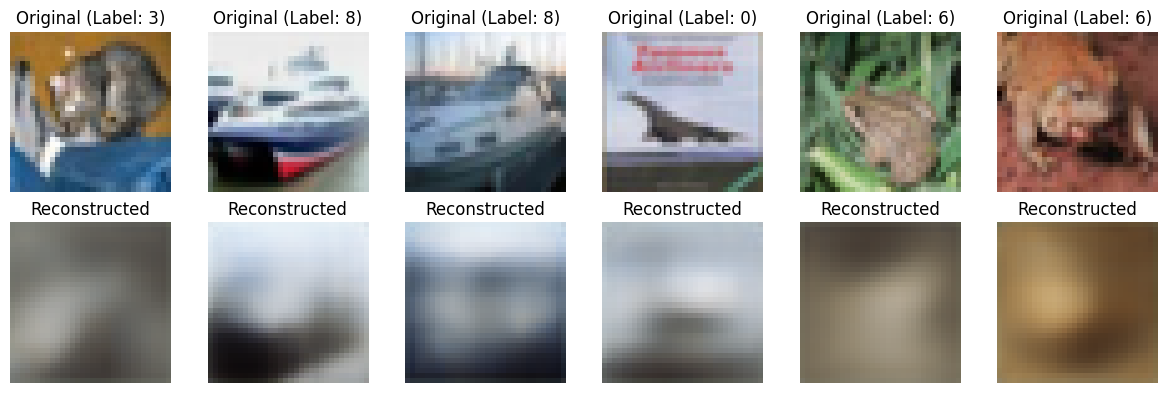


Generating random samples from decoder...


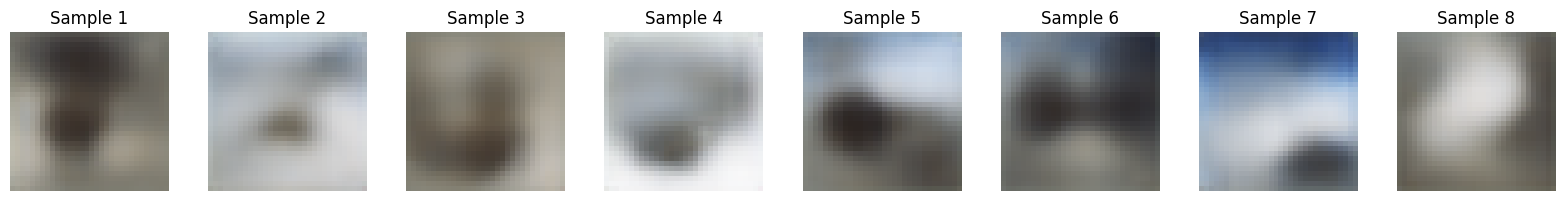

In [18]:
print("\n" + "="*60)
print("PART B.2: RECONSTRUCTIONS & LATENT SPACE INTERPOLATION")
print("="*60)

# B.2.1: Show at least 6 reconstructions
print("\nShowing 6 reconstructions from test set...")
show_reconstructions(vae_best, cifar_test_loader, device, n=6)

print("\nGenerating random samples from decoder...")
sample_from_decoder(vae_best.decoder, best_config['latent_dim'], device, n=8)


Let $\mathcal{Z}$ be the space of your latent variable.
Let $z_1$ and $z_2$ be the two latent variables sampled from $\mathcal{Z}$.
The two variables can be conceptually linked together in the space by drawing a straight "line" between them.
Your task is to compute the locations of at least 4 points spaced equally on this line (hollow circles in the figure below), and decode them into images.

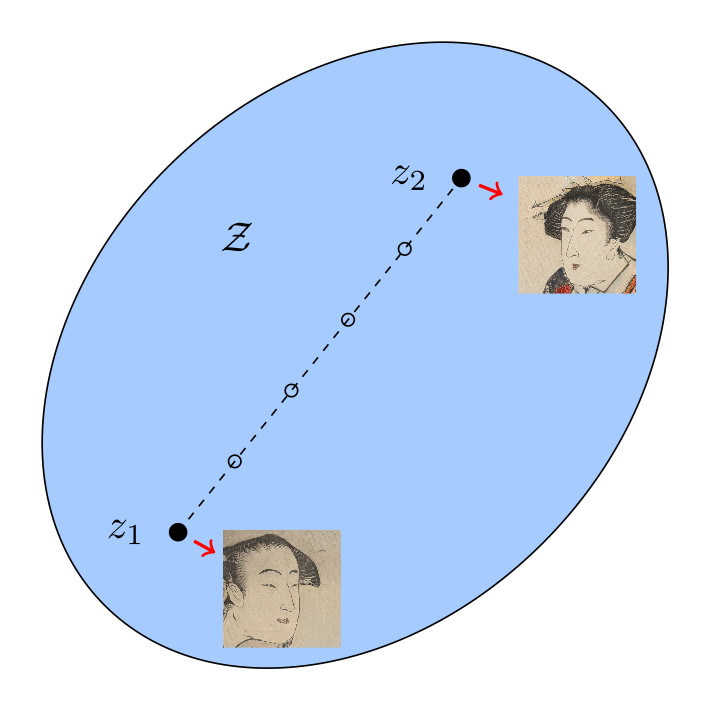

Here is a figure of another example of this procedure with 6 intermediate steps, where the red line corresponds to the decoder operation:

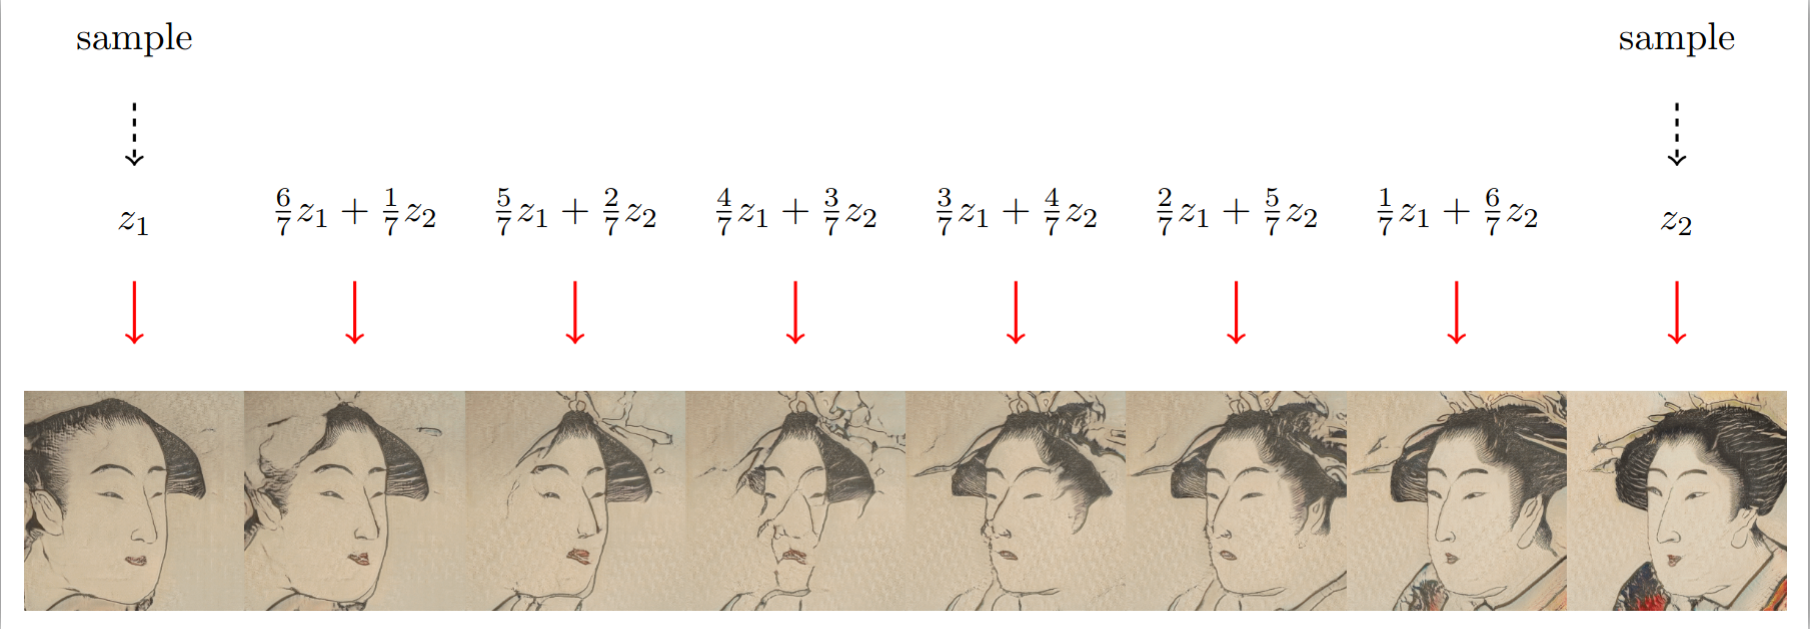

In the above, images from the ARC Ukiyo-e Faces Dataset were used to train the decoder.

Choose two sampled latent vectors, interpolate between them by visualising at least 4 steps in the intermediate reconstructions.

In [19]:
def interpolate_latents(model, z1=None, z2=None, steps=8):
    """
    Interpolate between two latent vectors and visualize the decoded images.
    Args:
        model: trained VAE model with a decoder
        z1: first latent vector (can be tensor or will sample random if None)
        z2: second latent vector (can be tensor or will sample random if None)
        steps: number of interpolation steps (including endpoints)
    Returns:
        interpolated_images: Tensor of decoded images [steps, C, H, W]
    """
    model.eval()

    # If z1 or z2 are None, sample random latent vectors
    if z1 is None:
        z1 = torch.randn(1, model.latent_dim).to(device)
    if z2 is None:
        z2 = torch.randn(1, model.latent_dim).to(device)

    # Ensure z1 and z2 are on the correct device and have batch dimension
    if len(z1.shape) == 1:
        z1 = z1.unsqueeze(0)
    if len(z2.shape) == 1:
        z2 = z2.unsqueeze(0)

    z1 = z1.to(device)
    z2 = z2.to(device)

    # Create interpolation weights using linspace
    # alphas go from 0 to 1, so we get: z1, ..., z2
    alphas = torch.linspace(0, 1, steps).to(device)

    # Interpolate: z_t = (1 - alpha) * z1 + alpha * z2
    # This creates a straight line in latent space from z1 to z2
    interpolated_images = []
    with torch.no_grad():
        for alpha in alphas:
            # Linear interpolation formula
            z_t = (1 - alpha) * z1 + alpha * z2
            # Decode the interpolated latent vector
            x_t = model.decoder(z_t)
            interpolated_images.append(x_t.cpu())

    # Concatenate all images
    interpolated_images = torch.cat(interpolated_images, dim=0)

    # Create a grid for visualization
    grid = utils.make_grid(interpolated_images, nrow=steps, normalize=True)

    # Plot
    plt.figure(figsize=(16, 3))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Latent Space Interpolation ({steps} steps from z1 to z2)")
    plt.axis("off")

    # Add labels for start and end
    plt.text(0.02, 0.95, 'z₁', transform=plt.gca().transAxes,
             fontsize=14, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.text(0.98, 0.95, 'z₂', transform=plt.gca().transAxes,
             fontsize=14, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.show()

    return interpolated_images

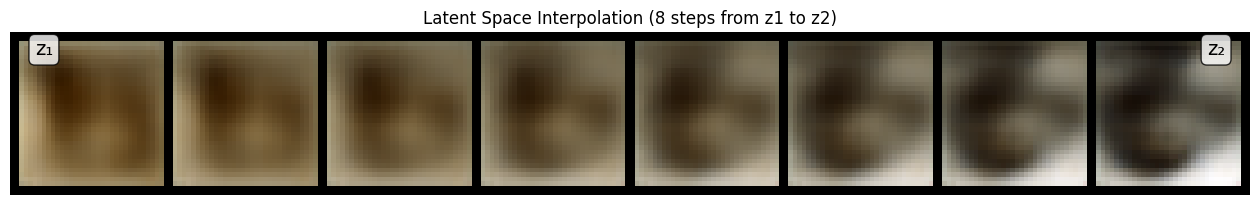

tensor([[[[0.6077, 0.6206, 0.5908,  ..., 0.5669, 0.5672, 0.5475],
          [0.6223, 0.5877, 0.5640,  ..., 0.5562, 0.5601, 0.5479],
          [0.6112, 0.5873, 0.5518,  ..., 0.5329, 0.5437, 0.5332],
          ...,
          [0.6946, 0.6926, 0.6772,  ..., 0.5648, 0.5914, 0.5816],
          [0.7008, 0.7078, 0.6969,  ..., 0.6042, 0.6085, 0.5931],
          [0.6649, 0.6804, 0.6786,  ..., 0.6108, 0.6031, 0.6021]],

         [[0.6075, 0.5998, 0.5659,  ..., 0.5475, 0.5478, 0.5284],
          [0.6024, 0.5579, 0.5280,  ..., 0.5218, 0.5304, 0.5270],
          [0.5873, 0.5517, 0.5103,  ..., 0.4893, 0.5057, 0.5028],
          ...,
          [0.6608, 0.6385, 0.6215,  ..., 0.5016, 0.5245, 0.5345],
          [0.6677, 0.6622, 0.6501,  ..., 0.5332, 0.5439, 0.5450],
          [0.6383, 0.6469, 0.6342,  ..., 0.5558, 0.5521, 0.5512]],

         [[0.5322, 0.5202, 0.4784,  ..., 0.4676, 0.4777, 0.4678],
          [0.5225, 0.4752, 0.4361,  ..., 0.4422, 0.4582, 0.4544],
          [0.5037, 0.4625, 0.4162,  ..., 0

In [20]:
interpolate_latents(vae_best, steps=8)